# Worm - Text Mining

## Table Of Contents:

* [Crawling](#bullet1)
* [Cleaning](#bullet2)
* [Descriptive Analysis](#bullet3)


Preambel

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import re, math
import seaborn as sns
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request

from stop_words import get_stop_words

In [2]:
#Notebook options
%matplotlib inline
sns.set_style("whitegrid")
matplotlib.rcParams['figure.figsize'] = [15,5]

plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize
plt.rc('figure', titlesize=18)  # fontsize of the figure title

## Crawling <a class="anchor" id="bullet1"></a>  

In [3]:
%%time
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux i686; rv:64.0) Gecko/20100101 Firefox/64.0'}
found = True
url = 'https://www.parahumans.net/2017/10/21/glow-worm-0-1/'
warddata = pd.DataFrame(columns=('Heading', 'Text'))
while found:
    # open link and save the info into warddata
    req = Request(url=url, headers=headers) 
    try:
        link = urlopen(req).read() 
    except urllib.error.HTTPError as err:
            print(err.code)
            continue
    soup = BeautifulSoup(link)
    title = soup.find("h1",  class_="entry-title").text
    text = soup.find('div', class_="entry-content").text.strip()
    warddata = warddata.append(pd.DataFrame({'Heading': [title], 'Text': [text]}), ignore_index=True)
    
    # get to next chapter 
    
    #url1 = soup.find('a', title="Next Chapter")
    url2 = soup.find('a', text='Next Chapter')
    url3 = soup.find('a', text=' Next Chapter')
    found = url2 or url3
    #if url1:
    #    url = soup.find('a', title="Next Chapter").attrs['href']
    #    print('url1')
    if url2:
        url = soup.find('a', text='Next Chapter').attrs['href']
    if url3:
        url = soup.find('a', text=' Next Chapter').attrs['href']



CPU times: user 37.1 s, sys: 968 ms, total: 38.1 s
Wall time: 6min 40s


In [4]:
# extract chapter text from raw text accounting for two special cases
def getText(x): 
    if x[:12] == 'Last Chapter':
        return re.findall('.*Next\sChapter\n(.+)\nLast\sChapter.*', x, re.DOTALL)[0].strip()
    elif x[:12] == 'Next Chapter':
        return re.findall('.*Next\sChapter\n(.+)\nNext\sChapter.*', x, re.DOTALL)[0].strip()
    else:
        return re.findall('.*Next\sChapter\n(.+)\n\s*Previous\sChapter.*', x, re.DOTALL)[0].strip()
          
warddata['Text'] = warddata['Text'].apply(getText)

## Cleaning <a class="anchor" id="bullet2"></a>  

In [5]:
#Add columns for number of letters, super- and subchapter (arc, chapter), and section (both combined)
def floating(x):
    if re.findall("\d+\.*\d*",x)!=[]:
        return re.findall("\d+\.*\d*",x)[0]
    else:
        return 0
    
warddata['Letters'] = warddata['Text'].apply(len)
warddata['Section'] = warddata['Heading'].apply(floating)
warddata['Arc'] = warddata['Heading'].apply(lambda x: math.trunc(float(floating(x))))
warddata['Chapter'] = warddata['Heading'].apply(lambda x: re.findall("\.(\d+).*",str(floating(x)))[0] if re.findall("\.(\d+).*",str(floating(x)))!=[] else 0)

In [6]:
# Get the chapter heading
def getHeading(x):
    if 'Interlude' in x or not (x[-1].isdigit()):
        return 'Interlude'
    else:
        return re.findall('(.+)–.+', x)[0].strip()
    

warddata['Heading'] = warddata['Heading'].apply(getHeading)

In [7]:
# Fix the interludes
warddata['InterludeNr'] = '0'
warddata['Interlude'] = False
heading = 'Wormy'
interludecount=0
for i,chapter in enumerate(warddata['Heading']):
    if chapter == 'Interlude':
        warddata.at[i, 'Interlude'] =  True
        warddata.at[i, 'InterludeNr'] = 'abcdefghijk'[interludecount]
        warddata.at[i, 'Heading'] = heading
        chapter= heading
        interludecount += 1
        lastinterlude = i
    if chapter != heading:
        if interludecount==1:
            warddata.at[lastinterlude, 'InterludeNr'] = ''
        interludecount=0
    heading = chapter

In [8]:
# Fix weird symbols in the text
warddata['Text'] = warddata['Text'].apply(lambda x: x.replace(' ',' ').replace('  ',' '))

In [9]:
warddata.to_csv('warddata.csv', index=False)

In [10]:
warddata = pd.read_csv('warddata.csv', dtype={'Section': str, 'Chapter': int})

## Descriptive Analysis <a class="anchor" id="bullet3"></a> 

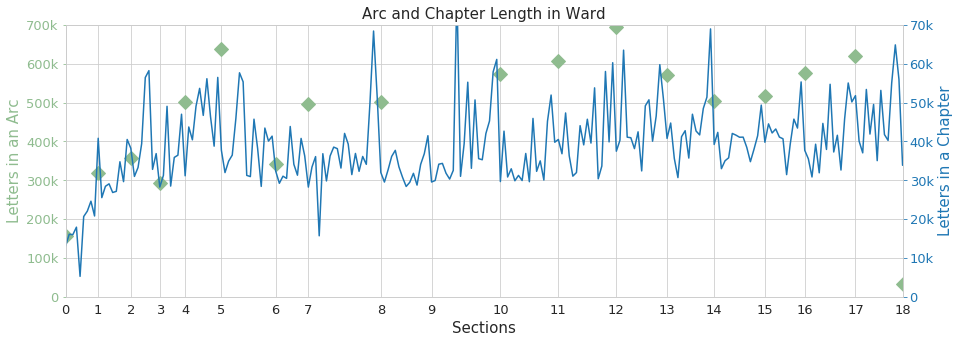

In [11]:
fig, ax1 = plt.subplots()
warddata[['Letters', 'Arc']].groupby('Arc').sum().set_index([warddata.index[warddata['Chapter']==1].tolist()])\
.plot(ax=ax1, color='darkseagreen', legend=False, marker='D', linewidth=0, markersize=10)
ax1.set_ylim((0,700000))
ax1.set_ylabel('Letters in an Arc', color='darkseagreen')
ax1.set_xticks(warddata.index[warddata['Chapter']==1].tolist())
ax1.set_xticklabels(warddata['Arc'][warddata['Chapter']==1])
ax1.set_yticklabels(['0', '100k', '200k', '300k', '400k', '500k', '600k', '700k'])
ax1.set_xlabel('Sections')
ax1.set_title('Arc and Chapter Length in Ward')
ax1.tick_params('y', colors='darkseagreen')

ax2 = ax1.twinx()
warddata['Letters'].plot(ax=ax2,grid=False)
ax2.tick_params('y', colors=sns.color_palette()[0])
ax2.set_ylim((0,70000))
ax2.set_yticklabels(['0', '10k', '20k', '30k', '40k', '50k', '60k', '70k'])
ax2.set_ylabel('Letters in a Chapter', color=sns.color_palette()[0])
plt.show()

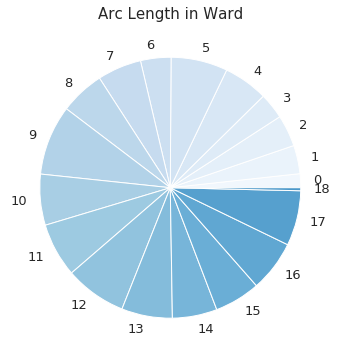

In [12]:
plt.figure(figsize=(6,6))
labels = set(warddata['Arc'])
colors = sns.color_palette("Blues", 31)
plt.pie(warddata[['Letters','Arc']].groupby('Arc').sum()['Letters'], labels=labels, colors=colors)
plt.title('Arc Length in Ward')
plt.show()

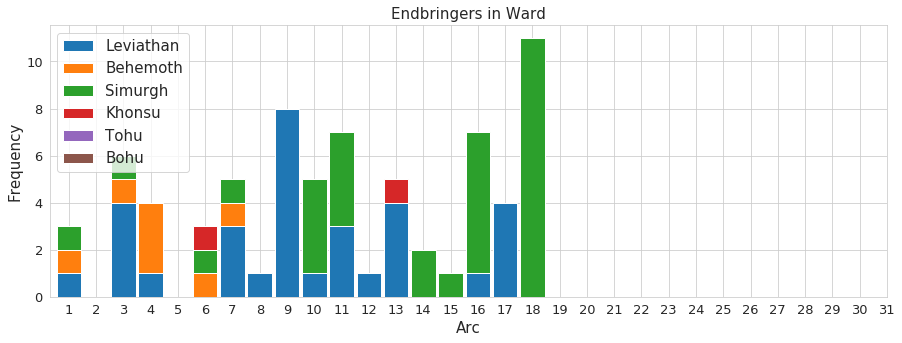

In [13]:
endbringers = ['Leviathan', 'Behemoth', 'Simurgh', 'Khonsu', 'Tohu', 'Bohu']
for endbringer in endbringers:
    warddata[endbringer] = warddata['Text'].apply(lambda x: len(re.findall(endbringer, x)))

warddata[endbringers + ['Arc']].groupby('Arc').sum().plot(kind='bar', stacked=True, figsize=(15,5), width=0.9)
plt.xticks(range(31), range(1,32), rotation='horizontal')
plt.title('Endbringers in Ward')
plt.ylabel('Frequency')
plt.xlabel('Arc')
plt.legend(loc='upper left')
plt.show()